## 預測下一個顧客進來要等多久

關於要處理時續性的機器學習問題
使用 RNN 中的 LSTM

- Arrival time : 到達時間
- X1：等待時間
- X2：服務時間
- X3：等待時間＋服務時間＝離開時間

要預測等待時間，可以當作 `預測 X1`。
等待時間與前面的人的服務時間會有直接地影響，故覺得應該只需要保留：
- Arrival time : 到達時間
- X1：等待時間
- X2：服務時間

透過這三個欄位來進行預測！

In [42]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [29]:
df = pd.read_excel("./Supplementary DATA on Queues/FIRST BANK (WEEK 1).xlsx", sheet_name="Sheet1")
df = df.iloc[:, :5]

# 移除奇怪的值 => 10,033
df = df.drop(266)
df["Arrival time"] = df["Arrival time"].astype("str").str.replace(".", ":")
df["Arrival time"] = pd.to_datetime(df["Arrival time"], format='%H:%M').dt.strftime("%H:%M")

df = df[['Arrival time', 'X1', 'X2']]

df

/var/folders/vc/svw_78hn1n79nnpst2w2mmyc0000gn/T/ipykernel_5537/1491962889.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Arrival time"] = df["Arrival time"].astype("str").str.replace(".", ":")


,Arrival time,X1,X2
0,08:00,11,28
1,08:00,13,25
2,08:00,14,26
3,08:00,9,26
4,08:00,14,23
...,...,...,...
875,14:58,11,23
876,14:59,15,27
877,14:59,14,27
878,14:59,13,29


In [30]:
def time_to_min(time_str):
    h, m = time_str.split(":")
    return int(h) * 60 + int(m)

time_cols = ["Arrival time"]  

for col in time_cols:
    df[col] = df[col].apply(time_to_min)

df

,Arrival time,X1,X2
0,480,11,28
1,480,13,25
2,480,14,26
3,480,9,26
4,480,14,23
...,...,...,...
875,898,11,23
876,899,15,27
877,899,14,27
878,899,13,29


訓練：參考前 20 筆，來預測 後面 5 筆 的等待時間

In [31]:
def normalize(df):
    df_norm = df.copy()
    features = ['X1', 'X2']
    df_norm[features] = df_norm[features].apply(lambda x: (x - x.mean()) / (x.max() - x.min())) 
    return df_norm

In [32]:
# 透過前 20筆 的 (Arrival time、X1、X2) 的數據去預測 接下來5筆  的 X1等待時間
# 每筆資料的 input size 是 (seq_length, feature_dim) = (20, 3)

def train_windows(df, the_train=20, the_predict=5):
  X_train, Y_train = [], []
  for i in range(df.shape[0]-the_predict-the_train):
      X_train.append(np.array(df.iloc[i:i+the_train]))
      Y_train.append(np.array(df.iloc[i+the_train:i+the_train+the_predict]["X1"]))
  return np.array(X_train), np.array(Y_train)

In [33]:
def split_data(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val

In [34]:
train = df.copy()
train_norm = normalize(train)
X_train, Y_train = train_windows(train_norm, 20, 5)
X_train, Y_train, X_val, Y_val = split_data(X_train, Y_train, 0.1)

In [40]:
train_norm

,Arrival time,X1,X2
0,480,-0.166667,0.337315
1,480,0.166667,-0.162685
2,480,0.333333,0.003982
3,480,-0.500000,0.003982
4,480,0.333333,-0.496018
...,...,...,...
875,898,-0.166667,-0.496018
876,899,0.500000,0.170648
877,899,0.333333,0.170648
878,899,0.166667,0.503982


In [41]:
print("X_train", X_train.shape)
print("Y_train", Y_train.shape)
print("X_val", X_val.shape)
print("Y_val", Y_val.shape)

# X_train: (樣本數, 時間步長, 特徵數) -> (769, 20, 3)
# Y_train: (樣本數, 預測長度) -> (769, 5)

X_train (769, 20, 3)
Y_train (769, 5)
X_val (85, 20, 3)
Y_val (85, 5)


In [62]:
model = Sequential()
model.add(LSTM(64, input_shape=(20, 3), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(5, activation='relu'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                                 
Total params: 17733 (69.27 KB)
Trainable params: 17733 (69.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
train = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/50
25/25 [==============================] - 1s 16ms/step - loss: 0.2148 - val_loss: 0.0871
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.1029 - val_loss: 0.0856
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0948 - val_loss: 0.0856
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0939 - val_loss: 0.0856
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0938 - val_loss: 0.0856
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0938 - val_loss: 0.0856
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0934 - val_loss: 0.0856
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0929 - val_loss: 0.0856
Epoch 9/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.0856
Epoch 10/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0937 - val_loss: 0.0856
Epoch 11/50
25/25 

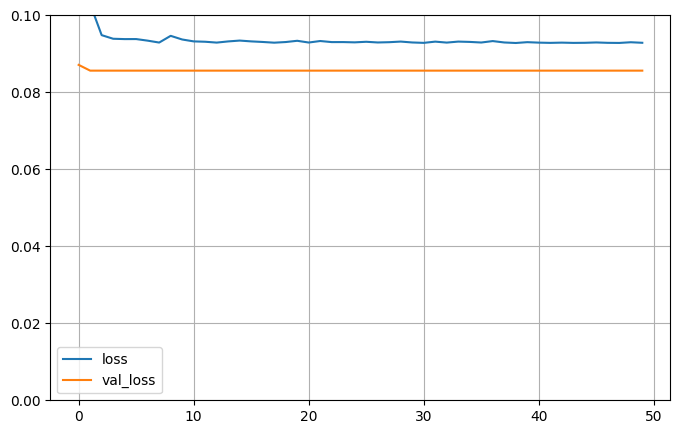

In [64]:
pd.DataFrame(train.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 0.1)
plt.show()